<a href="https://colab.research.google.com/github/SusanSagwa/Energy-Consumption-Prediction-In-Smart-Buildings-Using-Ensemble-Learning/blob/main/ECP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn==1.1.3
import sklearn
sklearn.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'1.1.3'

In [2]:
import os
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/EPdata'

# Data Preparation and Analysis

***Data dictionary***

**Building metadata**

1) building_id - Foreign key for the building metadata.

2) meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

3) timestamp - When the measurement was taken

4) meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

site_id - Foreign key for the weather files.

building_id - Foreign key for training.csv

primary_use - Indicator of the primary category of activities for the building

square_feet - Gross floor area of the building

year_built - Year building was opened

floor_count - Number of floors of the building

**Weather data from a meteorological station as close as possible to the site.**

site_id

air_temperature - Degrees Celsius

cloud_coverage - Portion of the sky covered in clouds, in oktas

dew_temperature - Degrees Celsius

precip_depth_1_hr - Millimeters

sea_level_pressure - Millibar/hectopascals

wind_direction - Compass direction (0-360)

wind_speed - Meters per second

In [5]:
def reduce_mem(df):
    result = df.copy()
    for col in result.columns:
        col_data = result[col]
        dn = col_data.dtype.name
        if not dn.startswith("datetime"):
            if dn == "object":  # only object feature has low cardinality
                result[col] = pd.to_numeric(col_data.astype("category").cat.codes, downcast="unsigned")
            elif dn.startswith("int") | dn.startswith("uint"):
                if col_data.min() >= 0:
                    result[col] = pd.to_numeric(col_data, downcast="unsigned")
                else:
                    result[col] = pd.to_numeric(col_data, downcast='integer')
            else:
                result[col] = pd.to_numeric(col_data, downcast='float')
    return result

def _delete_bad_sitezero(X, y):
    cond = (X.timestamp > '2016-05-20') | (X.site_id != 0) | (X.meter != 0)
    X = X[cond]
    y = y.reindex_like(X)
    return X.reset_index(drop=True), y.reset_index(drop=True)

def _extract_temporal(X, train=True):
    X['hour'] = X.timestamp.dt.hour
    X['weekday'] = X.timestamp.dt.weekday
    if train:
        # include month to create validation set, to be deleted before training
        X['month'] = X.timestamp.dt.month 
    # month and year cause overfit, could try other (holiday, business, etc.)
    return reduce_mem(X)
def load_data(source='train'):
    assert source in ['train','test']
    df = pd.read_csv(f'{path}/{source}.csv', parse_dates=['timestamp'])
    return reduce_mem(df)

def load_building():
    df = pd.read_csv(f'{path}/building_metadata.csv').fillna(-1)
    return reduce_mem(df)

def load_weather(source='train', fix_timezone=True, impute=True, add_lag=True):
    assert source in ['train','test']
    df = pd.read_csv(f'{path}/weather_{source}.csv', parse_dates=['timestamp'])
    if fix_timezone:
        offsets = [5,0,9,6,8,0,6,6,5,7,8,6,0,7,6,6]
        offset_map = {site: offset for site, offset in enumerate(offsets)}
        df.timestamp = df.timestamp - pd.to_timedelta(df.site_id.map(offset_map), unit='h')
    if impute:
        site_dfs = []
        for site in df.site_id.unique():
            if source == 'train':
                new_idx = pd.date_range(start='2016-1-1', end='2016-12-31-23', freq='H')
            else:
                new_idx = pd.date_range(start='2017-1-1', end='2018-12-31-23', freq='H')
            site_df = df[df.site_id == site].set_index('timestamp').reindex(new_idx)
            site_df.site_id = site
            for col in [c for c in site_df.columns if c != 'site_id']:
                site_df[col] = site_df[col].interpolate(limit_direction='both', method='linear')
                site_df[col] = site_df[col].fillna(df[col].median())
            site_dfs.append(site_df)
        df = pd.concat(site_dfs)
        df['timestamp'] = df.index
        df = df.reset_index(drop=True)
    if add_lag:
        df = add_lag_features(df, window=3)
    
    return reduce_mem(df)

def merged_dfs(source='train', fix_timezone=True, impute=True, add_lag=False):
    df = load_data(source=source).merge(load_building(), on='building_id', how='left')
    df = df.merge(load_weather(source=source, fix_timezone=fix_timezone, impute=impute, add_lag=add_lag),
                 on=['site_id','timestamp'], how='left')
    if source == 'train':
      X = df.drop('meter_reading', axis=1)  
      y = np.log1p(df.meter_reading)  # log-transform of target
      return X, y
    elif source == 'test':
      return df
   

In [6]:
X_train, y_train = merged_dfs(add_lag=False)
X_train = X_train.groupby('primary_use', group_keys=False).apply(lambda X: X.sample(6250))
X_train.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
15625611,915,0,2016-10-11 02:00:00,9,0,205141,-1.0,-1.0,12.800000,0.00000,8.9,0.000000,1019.599976,0.000000,0.0
8014654,412,0,2016-05-28 13:00:00,3,0,110000,-1.0,-1.0,30.000000,4.00000,20.6,0.000000,1020.400024,170.000000,5.7
2126126,217,0,2016-02-08 13:00:00,2,0,282946,2003.0,-1.0,28.299999,2.00000,-7.8,0.000000,1018.099976,50.000000,4.6
10449734,1030,1,2016-07-10 19:00:00,11,0,68030,-1.0,-1.0,18.400000,2.00000,14.3,2.614458,1015.599976,280.000000,1.0
15167664,1018,1,2016-10-03 00:00:00,10,0,186840,-1.0,2.0,16.745455,1.74359,1.6,0.000000,998.990906,229.090912,5.7


In [7]:
# preprocessing
X_train, y_train = _delete_bad_sitezero(X_train, y_train)
X_train = _extract_temporal(X_train)

# remove timestamp and other unimportant features
to_drop = ['timestamp','sea_level_pressure','wind_direction','wind_speed', 'precip_depth_1_hr', 'year_built', 'building_id', 'site_id']
X_train.drop(to_drop, axis=1, inplace=True)

gc.collect()

21

In [8]:
X_train

,meter,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,hour,weekday,month
0,0,0,205141,-1.0,12.800000,0.00000,8.900000,2,1,10
1,0,0,110000,-1.0,30.000000,4.00000,20.600000,13,5,5
2,0,0,282946,-1.0,28.299999,2.00000,-7.800000,13,0,2
3,1,0,68030,-1.0,18.400000,2.00000,14.300000,19,6,7
4,1,0,186840,2.0,16.745455,1.74359,1.600000,0,0,10
...,...,...,...,...,...,...,...,...,...,...
97232,0,15,39464,-1.0,25.600000,6.00000,15.600000,14,5,8
97233,2,15,19059,-1.0,16.100000,4.00000,-0.600000,12,6,5
97234,0,15,202829,-1.0,6.100000,8.00000,-0.600000,18,0,2
97235,0,15,27318,-1.0,31.100000,4.00000,19.400000,8,6,7


In [9]:
X_train.to_csv("/content/drive/MyDrive/Econsume.csv")

In [10]:
list(X_train.columns)

['meter',
 'primary_use',
 'square_feet',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'hour',
 'weekday',
 'month']

In [11]:
X = pd.concat([X_train, y_train], axis=1)

del X_train, y_train
gc.collect()

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97237 entries, 0 to 97236
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   meter            97237 non-null  uint8  
 1   primary_use      97237 non-null  uint8  
 2   square_feet      97237 non-null  uint32 
 3   floor_count      97237 non-null  float32
 4   air_temperature  97237 non-null  float32
 5   cloud_coverage   97237 non-null  float32
 6   dew_temperature  97237 non-null  float32
 7   hour             97237 non-null  uint8  
 8   weekday          97237 non-null  uint8  
 9   month            97237 non-null  uint8  
 10  meter_reading    97237 non-null  float32
dtypes: float32(5), uint32(1), uint8(5)
memory usage: 2.7 MB


In [12]:
Y = X['meter_reading']

In [13]:
dropping = ['meter_reading']
X.drop(dropping, axis=1, inplace=True)

In [14]:
X.shape

(97237, 10)

In [15]:
Y.head()

0    5.247024
1    4.091173
2    5.901841
3    0.000000
4    0.000000
Name: meter_reading, dtype: float32

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [17]:
X_train.shape

(77789, 10)

In [18]:
X_test.shape

(19448, 10)

In [19]:
y_train.shape

(77789,)

In [20]:
y_test.shape

(19448,)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

**Decission Tree**

In [22]:
parameters = {'max_depth': [3,5,7,9,11,15]}


decission_tree = GridSearchCV(estimator = DecisionTreeRegressor(),
                        param_grid = parameters,
                        cv = 3, 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [23]:
print("Best Decision Tree Estimator ",decission_tree.best_estimator_)
print("Best Decision Tree Paramteres are : ", decission_tree.best_params_)

Best Decision Tree Estimator  DecisionTreeRegressor(max_depth=11)
Best Decision Tree Paramteres are :  {'max_depth': 11}


In [24]:
DecissionTree = DecisionTreeRegressor(max_depth=15)
DecissionTree.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=15)

**SVM**

In [25]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.svm import LinearSVR
lsvr = LinearSVR(random_state=0, tol=1e-5)
lsvr.fit(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=0, tol=1e-05)

In [26]:
from sklearn import svm

svr_model = svm.SVR(gamma = 'scale')
fit_model = svr_model.fit(x_train , y_train)

**Ensemble Learner**

In [27]:
estimators = [
              #('lsvr', LinearSVR()),
              ('svr_model', SVR()),
              ('decission_tree', DecisionTreeRegressor())
              ]

In [28]:
final_estimator = GradientBoostingRegressor(
        n_estimators=200, subsample=0.5, min_samples_leaf=25, max_features=5,
        random_state=42)
Ensemble_model = StackingRegressor(
      estimators=estimators,
      final_estimator=final_estimator)

In [29]:
Ensemble_model.fit(x_train, y_train)

StackingRegressor(estimators=[('svr_model', SVR()),
                              ('decission_tree', DecisionTreeRegressor())],
                  final_estimator=GradientBoostingRegressor(max_features=5,
                                                            min_samples_leaf=25,
                                                            n_estimators=200,
                                                            random_state=42,
                                                            subsample=0.5))

**Model Evaluation and Selection**

In [30]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [31]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    adds = abs(predictions + test_labels)/2
    smape = np.mean(errors / adds) * 100
    mape = 100 * np.mean(errors / test_labels)
    r_score = 100*r2_score(test_labels,predictions)
    accuracy = 100 - smape
    print(model,'\n')
    print('Average Error(Mean Absolute Error)       : {:0.4f} degrees'.format(np.mean(errors)))
    print('Variance score R^2  : {:0.2f}%' .format(r_score))
    print('Accuracy            : {:0.2f}%\n'.format(accuracy)) 

In [32]:
evaluate(lsvr, x_test, y_test)
evaluate(svr_model, x_test, y_test)
evaluate(decission_tree, x_test, y_test)
evaluate(Ensemble_model, x_test, y_test)

LinearSVR(random_state=0, tol=1e-05) 

Average Error(Mean Absolute Error)       : 1.4024 degrees
Variance score R^2  : 9.88%
Accuracy            : 59.29%

SVR() 

Average Error(Mean Absolute Error)       : 1.0103 degrees
Variance score R^2  : 41.56%
Accuracy            : 66.49%

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1) 

Average Error(Mean Absolute Error)       : 0.6623 degrees
Variance score R^2  : 66.53%
Accuracy            : 75.00%

StackingRegressor(estimators=[('svr_model', SVR()),
                              ('decission_tree', DecisionTreeRegressor())],
                  final_estimator=GradientBoostingRegressor(max_features=5,
                                                            min_samples_leaf=25,
                                                            n_estimators=200,
                

In [33]:
y4_pred = Ensemble_model.predict(x_test)

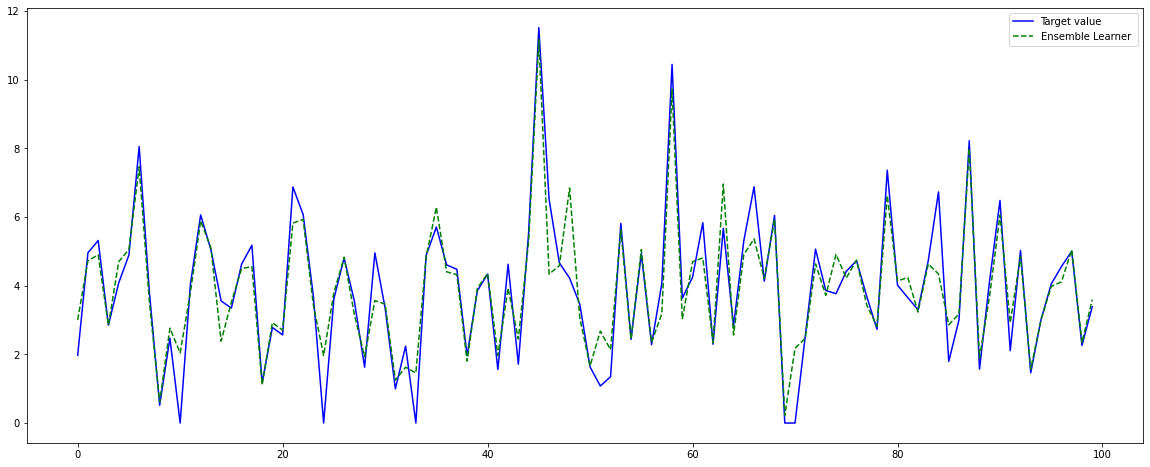

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,8))
plt.plot(y_test[:100].values,label='Target value',color='b')
plt.plot(y4_pred[:100],label='Ensemble Learner ', linestyle='--', color='g')

plt.legend(loc=1)

In [35]:
# save the file for deployment

import pickle
file = open('EnsembleModel.pkl','wb')
pickle.dump(Ensemble_model,file)
file.close()